In [5]:
import QuantLib as ql
from pandas import DataFrame
import numpy as np
import datetime
import matplotlib.pyplot as plt

### Idea

- The idea of this exercise is to perform <b>bootstrapping</b> to construct the theoretical <b>Spot Rate Cruve</b> for Treasuries
- The example is based on <b>Exhibit 5-5 given in Frank Fabozzi’s Bond Markets, Analysis and Strategies, Sixth Edition</b>

<br>
<br>

### 1. Setting up Constants and Conventions
- The below constants and conventions are defined for calculation
- For simplicity, we assume they are the same for both deposit rates and bond rates

In [6]:
calc_date = ql.Date(15, 1, 2015)
ql.Settings.instance().evaluationDate = calc_date

calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
business_convention = ql.Unadjusted
day_count = ql.Thirty360(ql.Thirty360.BondBasis)
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)
settlement_days = 0

<br>
<br>

### 2. Observe Yields on Treasury Securities from Market

- Assume the following <b>yield-to-maturity</b> for 20 Hypothtical <b>Treasury Securities</b> are observed from the market
- Notice that six-month and one-year issues are zero-coupon instruments

In [17]:
# Setting deposit maturities and rates
bill_maturities = [ql.Period(6, ql.Months), ql.Period(12, ql.Months)]
bill_rates = [5.25, 5.5]

# Setting bond maturities and rates
bond_maturities = [ql.Period(6*i, ql.Months) for i in range(3,21)]
bond_rates = [5.75, 6.0, 6.25, 6.5, 6.75, 6.80, 7.00, 7.1, 7.15,
              7.2, 7.3, 7.35, 7.4, 7.5, 7.6, 7.6, 7.7, 7.8]

# Combining deposit and bond maturities and rates
maturities = bill_maturities + bond_maturities
rates = bill_rates + bond_rates
DataFrame(list(zip(maturities,rates)),
          columns=["Maturities", "Curve"],
          index=['']*len(rates))

,Maturities,Curve
,6M,5.25
,12M,5.50
,18M,5.75
,24M,6.00
,30M,6.25
,36M,6.50
,42M,6.75
,48M,6.80
,54M,7.00
,60M,7.10


Text(0.5, 1.0, 'Treasury Yield Curve (YTM)')

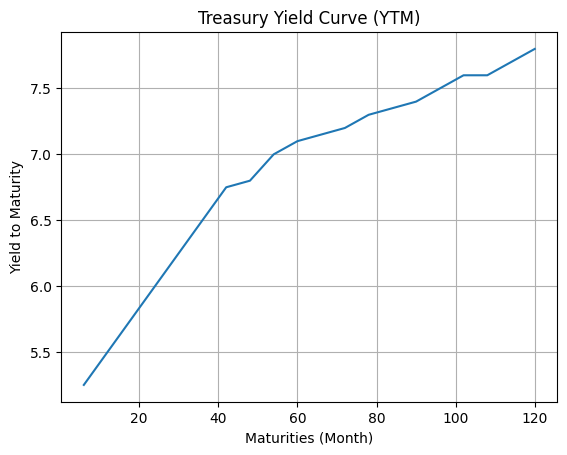

In [18]:
maturities_plot = [6*i for i in range(1,21)]
plt.figure(1)
plt.grid()
plt.plot(maturities_plot, rates)
plt.xlabel("Maturities (Month)")
plt.ylabel("Yield to Maturity")
plt.title("Treasury Yield Curve (YTM)")

<br>
<br>

### 3. Bootstrapping in Quantlib

#### 3.1 Setting up deposite rate helper and bond rate helper in Quantlib
- Rates are constructed as helper object in Quantlib

In [19]:
# Setting up deposit rate helper
bill_helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(r/100.0)),
                         m,
                         settlement_days,
                         calendar,
                         business_convention,
                         end_of_month,
                         day_count)
    for r, m in zip(bill_rates, bill_maturities)
]

# Setting up bond rate helper
bond_helpers = []
for r, m in zip(bond_rates, bond_maturities):
    termination_date = calc_date + m
    schedule = ql.Schedule(calc_date,
                           termination_date,
                           coupon_frequency,
                           calendar,
                           business_convention,
                           business_convention,
                           ql.DateGeneration.Backward,
                           end_of_month)
    bond_helper = ql.FixedRateBondHelper(
        ql.QuoteHandle(ql.SimpleQuote(face_amount)),
        settlement_days,
        face_amount,
        schedule,
        [r/100],
        day_count,
        business_convention)
    bond_helpers.append(bond_helper)

# Combinning the two helpers
rate_helpers = bill_helpers + bond_helpers

<br>

#### 3.2 Yield Curve Construction in Quantlib

- We then construct a piece wise yield curve using LogCubic Interpolation in Quantlib

In [20]:
yc_logcubicdiscount = ql.PiecewiseLogCubicDiscount(calc_date, rate_helpers, day_count)

<br>

#### 3.3 Extracting Spot Rates from Yield Curve
- The following is a wrapper function that will extract spot rates on a monthly interval

In [21]:
def get_spot_rates(yieldcurve, day_count, calendar=ql.UnitedStates(ql.UnitedStates.GovernmentBond), months=120):
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    calc_date = ref_date
    
    for month in range(0, months+1):
        yrs = month/12.0
        d = calendar.advance(ref_date, ql.Period(month, ql.Months))
        compounding = ql.Compounded
        freq = ql.Semiannual
        zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
        tenors.append(yrs)
        eq_rate = zero_rate.equivalentRate(day_count, compounding, freq, calc_date, d).rate()
        spots.append(100*eq_rate)

    return DataFrame(list(zip(tenors, spots)), columns=["Maturities", "Curve"], index=['']*len(spots))

spot_curve_lcd = get_spot_rates(yc_logcubicdiscount, day_count)
spot_curve_lcd

,Maturities,Curve
,0.000000,0.000000
,0.083333,5.211311
,0.166667,5.214626
,0.250000,5.220153
,0.333333,5.227891
...,...,...
,9.666667,7.981384
,9.750000,8.005292
,9.833333,8.028145
,9.916667,8.050187


<br>

#### 3.4 Plotting the Spot Curve

Text(0.5, 1.0, 'Spot Curve')

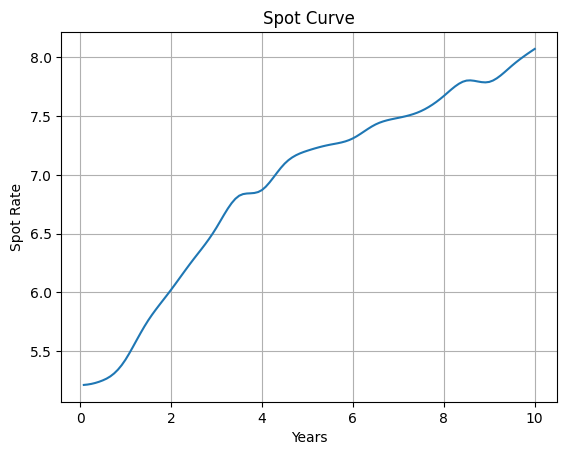

In [22]:
plt.figure(1)
plt.grid()
plt.plot(spot_curve_lcd['Maturities'][1:], spot_curve_lcd['Curve'][1:])
plt.xlabel("Years")
plt.ylabel("Spot Rate")
plt.title("Spot Curve")